In [178]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Arial']

In [179]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [180]:
def bkg_corrector(bkg_list,data_list):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [181]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))
#defining the gaussian

In [182]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess,maxfev=10000)
    gauss=function(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [183]:
def graphfitter(range_list,num_peak,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    centroid_list=[]
    cent_error_list=[]
    # for peak_num in num_peak:
    for peaks in range(0,num_peak):
        ranged_channel,fit_gauss,mu,cov = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        cent_error_list.append(centroid_error[1])
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
        centroid_list.append(mu[1])
    return ranged_channel_list, fit_gauss_list,centroid_list,cent_error_list

In [184]:
bkg=extract_mca_data("team_battery/bkg_10_1789.mca")

In [185]:
raw_E_spectrum_fe=extract_mca_data("team_battery/fe_10_1789_spectrum.mca")
raw_E_spectrum_am=extract_mca_data("team_battery/am_10_1790_spectrum.mca")
raw_E_spectrum_ba=extract_mca_data("team_battery/ba_10_1790_spectrum.mca")

In [186]:
channel_no=np.arange(1,len(raw_E_spectrum_fe)+1)

In [187]:
E_spectrum_fe=bkg_corrector(bkg,raw_E_spectrum_fe)
E_spectrum_am=bkg_corrector(bkg,raw_E_spectrum_am)
E_spectrum_ba=bkg_corrector(bkg,raw_E_spectrum_ba)

In [188]:
def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return (a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) + a2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

In [189]:
def alt_double_gaussian(x, a1, mu1, sigma1, mu2, sigma2):
    return (10*a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) + a1 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

In [190]:
def double_gauss_graphfitter(range_list,num_peak,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    mu1_list=[]
    mu2_list=[]
    # for peak_num in num_peak:
    for peaks in range(0,num_peak):
        ranged_channel,fit_gauss,mu,cov = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1],mu[3])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
        mu1_list.append(mu[1])
        mu2_list.append(mu[4])
    return ranged_channel_list, fit_gauss_list,mu1_list,mu2_list

In [191]:
def double_gauss_peak_fitter(function, channel, data_list,fit_range,gauss1_range,gauss2_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0][0]:fit_range[0][1]],data_list[fit_range[0][0]:fit_range[0][1]],p0=init_guess,maxfev=5000)
    gauss1=gaussian(channel[gauss1_range[0]:gauss1_range[1]],mu[0],mu[1],mu[2])
    gauss2=gaussian(channel[gauss2_range[0]:gauss2_range[1]],mu[3],mu[4],mu[5])
    channel_gauss1=channel[gauss1_range[0]:gauss1_range[1]]
    channel_gauss2=channel[gauss2_range[0]:gauss2_range[1]]
    return channel_gauss1,channel_gauss2, mu, cov, gauss1,gauss2

In [192]:
def alt_double_gauss_peak_fitter(function, channel, data_list,fit_range,gauss1_range,gauss2_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0][0]:fit_range[0][1]],data_list[fit_range[0][0]:fit_range[0][1]],p0=init_guess,maxfev=5000)
    gauss1=gaussian(channel[gauss1_range[0]:gauss1_range[1]],10*mu[0],mu[1],mu[2])
    gauss2=gaussian(channel[gauss2_range[0]:gauss2_range[1]],mu[0],mu[3],mu[4])
    channel_gauss1=channel[gauss1_range[0]:gauss1_range[1]]
    channel_gauss2=channel[gauss2_range[0]:gauss2_range[1]]
    return channel_gauss1,channel_gauss2, mu, cov, gauss1,gauss2

The fitting range for peak 0: 25 39
The centroid for peak 0: 31.802092483355636
The error on the centroid fit for peak 0: 0.16629906722532523
The fitting range for peak 1: 46 80
The centroid for peak 1: 61.418236776464596
The error on the centroid fit for peak 1: 0.06206415618343853


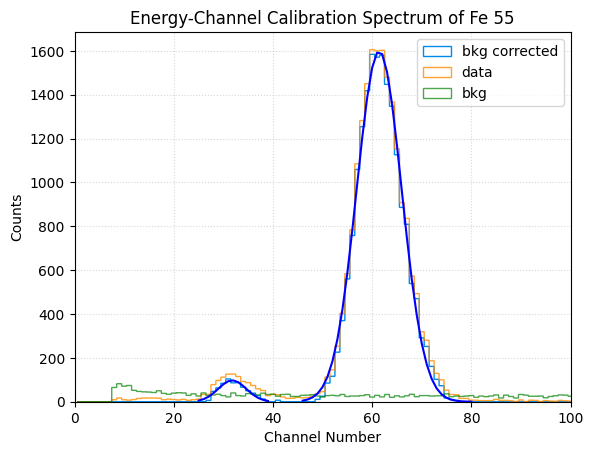

In [193]:
fe_fitting_range=[[24,39],[45,80]]
fe_p0=[[100,33,10],[1600,60,10]]
fe_range_channnel,fit_fe_gauss,fe_centroid_list,fe_cent_error=graphfitter(fe_fitting_range,2,gaussian,channel_no,E_spectrum_fe,fe_p0)
# Create bin edges from channel_no (assuming sorted integers)
channel_edges = np.arange(channel_no.min()-0.5, channel_no.max()+1.5, 1)

# Histograms with channel_no as bin edges, data as heights
plt.hist(channel_edges[:-1], bins=channel_edges, weights=E_spectrum_fe, histtype='step',
         label='bkg corrected', alpha=1, color="#008aec")
plt.hist(channel_edges[:-1], bins=channel_edges, weights=raw_E_spectrum_fe, histtype='step',
         label='data', alpha=0.8, color='darkorange')
plt.hist(channel_edges[:-1], bins=channel_edges, weights=bkg, histtype='step',
         label='bkg', alpha=0.7, edgecolor='green')

plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy-Channel Calibration Spectrum of Fe 55")
plt.legend()
plt.xlim(0,100)

# Fit curves overlay (these stay as plt.plot since they're continuous fits)
for fitpeak in range(0,len(fe_fitting_range)):
    plt.plot(fe_range_channnel[fitpeak],fit_fe_gauss[fitpeak],color='blue', linewidth=1.5)
plt.grid(True,linestyle=':',alpha=0.5,which='major')
plt.show()

The fitting range for peak 0: 25 40
The centroid for peak 0: 31.801129881527217
The error on the centroid fit for peak 0: 0.15977733326854088
The fitting range for peak 0: 41 79
The centroid for peak 0: 61.09792277759918 68.92917394402522
The error on the centroid fit for peak 0: 0.05711859628813114


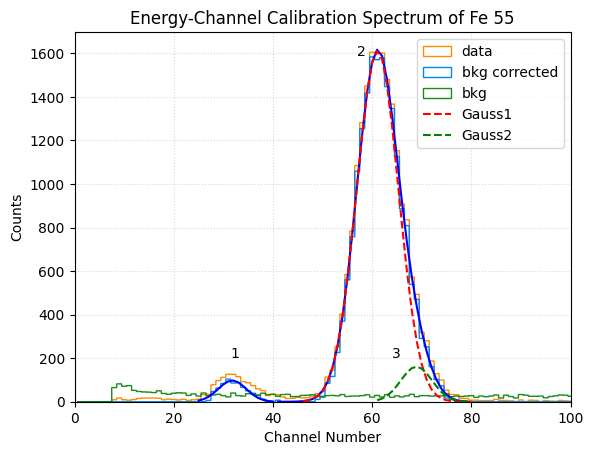

0.47751000974639934


In [194]:
fe_fitting_range_1=[[24,40]]
fe_p0_1=[[100,33,10]]
fe_range_channnel_1,fit_fe_gauss_1,fe_centroid_list_1,fe_cent_error_1=graphfitter(fe_fitting_range_1,1,gaussian,channel_no,E_spectrum_fe,fe_p0_1)

fe_fitting_range=[[40,79]]
fe_p0=[[300,60,5,65,15]]
gauss1_range=[45,80]
gauss2_range=[60,80]
fe_range_channnel,fit_fe_gauss,mu1_list,mu2_list=double_gauss_graphfitter(fe_fitting_range,1,alt_double_gaussian,channel_no,E_spectrum_fe,fe_p0)

    
channel_gauss1,channel_gauss2, mu, cov, gauss1,gauss2=alt_double_gauss_peak_fitter(alt_double_gaussian,channel_no,E_spectrum_fe,fe_fitting_range,gauss1_range,gauss2_range,fe_p0)

# Create bin edges from channel_no (assuming sorted integers)
channel_edges = np.arange(channel_no.min()-0.5, channel_no.max()+1.5, 1)

# Histograms with channel_no as bin edges, data as heights
plt.hist(channel_edges[:-1], bins=channel_edges, weights=raw_E_spectrum_fe, histtype='step',
         label='data', alpha=1, edgecolor='darkorange')
plt.hist(channel_edges[:-1], bins=channel_edges, weights=E_spectrum_fe, histtype='step',
         label='bkg corrected', alpha=1, color="#008aec")
plt.hist(channel_edges[:-1], bins=channel_edges, weights=bkg, histtype='step',
         label='bkg', alpha=0.9, edgecolor='green')

# Rest of your plotting code remains the same
plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy-Channel Calibration Spectrum of Fe 55")
plt.legend()
plt.xlim(0,100)

for fitpeak in range(0,len(fe_fitting_range_1)):
    plt.plot(fe_range_channnel_1[fitpeak],fit_fe_gauss_1[fitpeak],color='blue', linewidth=1.5)

for fitpeak in range(0,len(fe_fitting_range)):
    plt.plot(fe_range_channnel[fitpeak],fit_fe_gauss[fitpeak],color='blue', linewidth=1.5)


plt.text(31.5,200,'1')
plt.text(57,1590,'2')
plt.text(64,200,'3')

plt.plot(channel_gauss1,gauss1, 'r--', linewidth=1.5, label='Gauss1')
plt.plot(channel_gauss2,gauss2, 'g--', linewidth=1.5, label='Gauss2')
plt.legend()
plt.grid(True,linestyle=':',alpha=0.5,which='major')
plt.show()

fe_3rd_peak=mu[3]
fe_3rd_peak_error=np.sqrt(np.diag(cov))[3]
print(fe_3rd_peak_error)



The fitting range for peak 0: 261 340
The centroid for peak 0: 301.4192177263182
The error on the centroid fit for peak 0: 0.3652236499077082


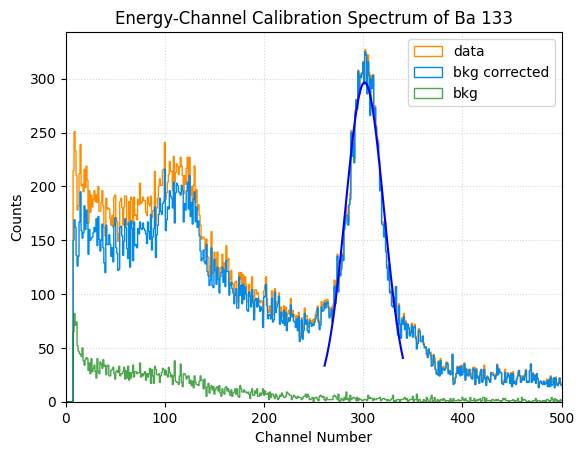

In [195]:
ba_fitting_range=[[260,340]]
ba_p0=[[300,290,30]]
ba_range_channnel,fit_ba_gauss,ba_centroid_list,ba_cent_error=graphfitter(ba_fitting_range,1,gaussian,channel_no,E_spectrum_ba,ba_p0)
# Create bin edges for histogram (each channel = 1 bin)
channel_edges = np.arange(channel_no.min()-0.5, channel_no.max()+1.5, 1)

# Plot step histograms with specified colors and alphas
plt.hist(channel_edges[:-1], bins=channel_edges, weights=raw_E_spectrum_ba, 
         label='data', histtype='step', color='darkorange', alpha=1.0)
plt.hist(channel_edges[:-1], bins=channel_edges, weights=E_spectrum_ba, 
         label='bkg corrected', histtype='step', color="#008aec", alpha=1)
plt.hist(channel_edges[:-1], bins=channel_edges, weights=bkg, 
         label='bkg', histtype='step', color='green', alpha=0.7)  # default matplotlib blue

# Overlay Gaussian fit curve
plt.plot(ba_range_channnel[0], fit_ba_gauss[0], color='blue', linewidth=1.5)

plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy-Channel Calibration Spectrum of Ba 133")
plt.xlim(0,500)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5, which='major')
plt.show()

[np.float64(0.16629906722532523), np.float64(0.06206415618343853), np.float64(0.3652236499077082)]


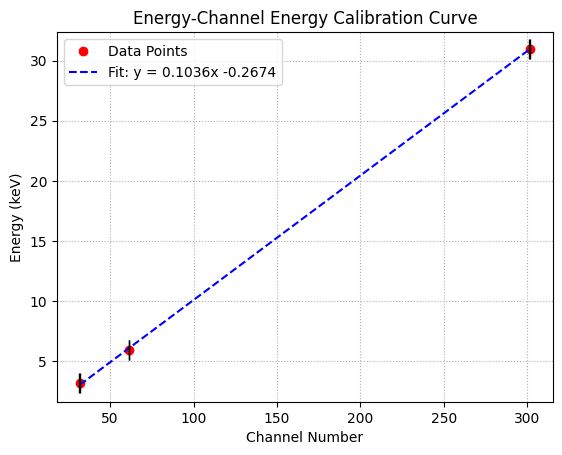

In [196]:
all_centroid_list = [x for sublist in [fe_centroid_list] for x in sublist]
# all_centroid_list.append(fe_3rd_peak)
all_centroid_list.append(ba_centroid_list[0])

all_cent_error=[x for sublist in [fe_cent_error] for x in sublist]
# all_cent_error.append(fe_3rd_peak_error)
all_cent_error.append(ba_cent_error[0])

print(all_cent_error)

# energy_list = [3.2, 5.899, 6.49, 30.973]
energy_list = [3.2, 5.899, 30.973]
energy_err_list=[]


fit = np.polyfit(all_centroid_list, energy_list, 1)
lin_fit = np.poly1d(fit)


x_fit = np.linspace(min(all_centroid_list), max(all_centroid_list), 100)
y_fit = lin_fit(x_fit)


plt.plot(all_centroid_list, energy_list, "r.", label="Data Points",ms=12)
plt.plot(x_fit, y_fit, "b--", label=f"Fit: y = {fit[0]:.4f}x {fit[1]:.4f}")
plt.errorbar(all_centroid_list,energy_list,xerr=all_cent_error,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.title("Energy-Channel Energy Calibration Curve")
plt.xlabel("Channel Number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.grid(True, linestyle=':')
# plt.xlim(30,35)
plt.show()

In [197]:
print(lin_fit)
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1036*(channels[i]) - 0.2674
        if energy>0:
            energy_list.append(energy)
    return energy_list

 
0.1036 x - 0.2674


In [198]:
print(lin_fit)
def energy_cali_int(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1036*(channels[i]) - 0.2674
        if energy>0:
            energy_list.append(int(energy))
    return energy_list

 
0.1036 x - 0.2674


In [199]:
# print(lin_fit)
# def energy_cali(channels):
#     energy_list=[]
#     for i in range(0,len(channels)):
#         energy=0.1040*(channels[i]) - 0.4074
#         if energy>0:
#             energy_list.append(energy)
#     return energy_list

In [206]:
energy_list=energy_cali(channel_no)
energy_list=np.array(energy_list)
print(energy_list)

[4.340000e-02 1.470000e-01 2.506000e-01 ... 1.056118e+02 1.057154e+02
 1.058190e+02]


In [201]:
am_fitting_range=[[129,155],[155,195],[195,235],[240,290],[560,640]]
# am_p0=[[550,135,7],[700,170,10],[300,200,10],[300,260,200],[170,520,16]]
am_p0=[[550,13.7185,1],[700,17.3446,1],[300,20.4526,1],[300,26.6686,1],[170,53.6046,1]]

In [202]:
for j in range(0,len(am_p0)):
    ene_am_p0=energy_cali(am_p0[j])
    print(ene_am_p0[1])

ene_cal_am_fitting_range=[]
for i in range(0,len(am_fitting_range)):
    energy_cal_temp=energy_cali_int(am_fitting_range[i])
    ene_cal_am_fitting_range.append(energy_cal_temp)
print(ene_cal_am_fitting_range)

1.1538366
1.5295005599999998
1.8514893599999998
2.4954669600000003
5.286036559999999
[[13, 15], [15, 19], [19, 24], [24, 29], [57, 66]]


In [203]:
# am_fitting_range=[[13,20],[16,20],[20,24],[24,30],[58,66]]
# am_p0=[[550,10,7],[700,17,10],[300,24,10],[300,26,20],[170,60,16]]
# am_range_channnel,fit_am_gauss,am_centroid_list,am_cent_error=graphfitter(am_fitting_range,2,gaussian,energy_list,E_spectrum_am[-(len(energy_list)):],am_p0)

In [207]:
# am_fitting_range=[[129,155],[155,195],[195,235],[240,290],[560,640]]
# am_p0=[[550,135,7],[700,170,10],[300,200,10],[300,260,200],[170,520,16]]
# am_range_channnel,fit_am_gauss,am_centroid_list,am_cent_error=graphfitter(am_fitting_range,len(am_fitting_range),gaussian,channel_no,E_spectrum_am,am_p0)
am_range_channnel,fit_am_gauss,am_centroid_list,am_cent_error=graphfitter(ene_cal_am_fitting_range,len(ene_cal_am_fitting_range),gaussian, energy_list,E_spectrum_am,am_p0)
peak_height=[600,700,350,250,200] 


#Create energy bin edges from calibrated energies
#energy_list has length N (one value per channel). Make N+1 edges:
energy_edges = np.concatenate([energy_list, [energy_list[-1] + (energy_list[-1] - energy_list[-2])]])

# High contrast step histograms (top to bottom: data, bkg-corrected, bkg)
plt.hist(energy_edges[:-1], bins=energy_edges, weights=raw_E_spectrum_am[-(len(energy_list)):],
         label='data', histtype='step', color='darkorange', alpha=1.0)

plt.hist(energy_edges[:-1], bins=energy_edges, weights=E_spectrum_am[-(len(energy_list)):],
         label='bkg corrected', histtype='step', color='#00a8ec', alpha=1)

plt.hist(energy_edges[:-1], bins=energy_edges, weights=bkg[-(len(energy_list)):],
         label='bkg', histtype='step', color='green', alpha=0.7)

plt.xlabel("Energy (keV)")   # or whatever unit your calibration gives
plt.ylabel("Counts")
plt.title("Energy-Channel Calibration Spectrum of Am 241")
# plt.xlim(0, 650)
plt.legend()


# # Create bin edges for histogram (each channel = 1 bin)
# channel_edges = np.arange(channel_no.min()-0.5, channel_no.max()+1.5, 1)

# # High contrast step histograms (top to bottom: data, bkg-corrected, bkg)
# plt.hist(channel_edges[:-1], bins=channel_edges, weights=raw_E_spectrum_am, 
#          label='data', histtype='step', color='darkorange', alpha=1.0)
# plt.hist(channel_edges[:-1], bins=channel_edges, weights=E_spectrum_am, 
#          label='bkg corrected', histtype='step', color="#008aec", alpha=1)
# plt.hist(channel_edges[:-1], bins=channel_edges, weights=bkg, 
#          label='bkg', histtype='step', color='green', alpha=0.7)

# plt.xlabel("Channel Number")
# plt.ylabel("Counts")
# plt.title("Energy-Channel Calibration Spectrum of Am 241")
# plt.xlim(0,650)
# plt.legend()

for fitpeak in range(0,len(am_fitting_range)):
    plt.plot(am_range_channnel[fitpeak],fit_am_gauss[fitpeak],color='blue', linewidth=1.5)
    plt.text(am_centroid_list[fitpeak],peak_height[fitpeak],f'{fitpeak+1}')

plt.grid(True,linestyle=':',alpha=0.5,which='major')
plt.show()


print(energy_cali(am_centroid_list))

print(lin_fit)
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1036*(channels[i]) - 0.2674
        energy_list.append(energy)
    return energy_list

print(energy_cali(am_cent_error))

TypeError: The number of func parameters=3 must not exceed the number of data points=2

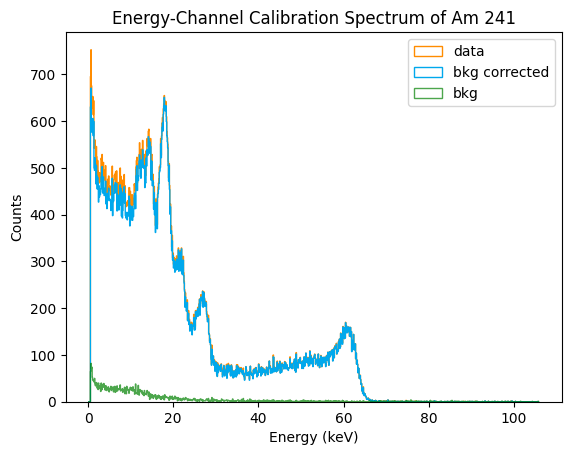

In [208]:
# Create energy bin edges from calibrated energies
# energy_list has length N (one value per channel). Make N+1 edges:
energy_edges = np.concatenate([energy_list, [energy_list[-1] + (energy_list[-1] - energy_list[-2])]])

# High contrast step histograms (top to bottom: data, bkg-corrected, bkg)
plt.hist(energy_edges[:-1], bins=energy_edges, weights=raw_E_spectrum_am[-(len(energy_list)):],
         label='data', histtype='step', color='darkorange', alpha=1.0)

plt.hist(energy_edges[:-1], bins=energy_edges, weights=E_spectrum_am[-(len(energy_list)):],
         label='bkg corrected', histtype='step', color='#00a8ec', alpha=1)

plt.hist(energy_edges[:-1], bins=energy_edges, weights=bkg[-(len(energy_list)):],
         label='bkg', histtype='step', color='green', alpha=0.7)

plt.xlabel("Energy (keV)")   # or whatever unit your calibration gives
plt.ylabel("Counts")
plt.title("Energy-Channel Calibration Spectrum of Am 241")
# plt.xlim(0, 650)
plt.legend()
